# Dealing with Overfitting in PyTorch

## Train Test and Validate in PyTorch

We will start this section by separating the dataset into the training, validation and testing datasets.

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

The `MNIST` object does not provide any functionality to get a validation dataset out of the box. We will download the training and testing datasets first and divide the training dataset into two parts: one for training one for validation.

In [2]:
train_validation_dataset = MNIST(root="../datasets/", train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(root="../datasets", train=False, download=False, transform=T.ToTensor())

We use the `train_test_split` function from sklearn to generate indices. Those indices indicate if a particular sample is going to be used for training or testing. We conduct a stratified split to keep the distribution of labels consistent. 90% of the data is going to be used for training and 10% for validation.

In [3]:
stratify = train_validation_dataset.targets.numpy()
train_idxs, val_idxs = train_test_split(
                                range(len(train_validation_dataset)),
                                stratify=stratify,
                                test_size=0.1)

To separate the dataset we use the `Subset` class which takes the original dataset and the indices and returns the modified dataset, where the samples that are not contained in the index list have been filtered out.

In [4]:
train_dataset = Subset(train_validation_dataset, train_idxs)
val_dataset = Subset(train_validation_dataset, val_idxs)

We keep the parameters similar to those in the previous section, but increase the number of epochs to show the effect of overfitting.

In [5]:
# parameters
DEVICE = ("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS=50
BATCH_SIZE=32
HIDDEN_SIZE_1 = 100
HIDDEN_SIZE_2 = 50
NUM_LABELS = 10
NUM_FEATURES = 28*28
ALPHA = 0.1

Now we have everything that we require to create the three dataloaders: one for training, one for validating, one for testing.

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True,
                              num_workers=4)

val_dataloader = DataLoader(dataset=val_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

test_dataloader = DataLoader(dataset=test_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

We create an additional function to track the performance: the average cross-entropy loss and the classification accuracy. One interesting feature you might notice is the call of `model.eval()`. We have not used this feature of PyTorch before, because there was no need to. This method puts the model in evaluation mode. Remember for example that dropout acts differently during training and evaluation, by scaling the outputs by $\dfrac{1}{1-p}$ during training and doing no scaling during testing. The method `torch.eval()` puts the model into evaluation mode and `torch.train()` puts the model into the training mode. There are more deep learning methods, that act differently during training and testing, which we will encounter in future lectures.

In [7]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(features)
            
            predictions = logits.max(dim=1)[1]
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In order to plot the performance of the  model over time, we create the `history` dictionary.

In [8]:
def train(train_dataloader, val_dataloader, model, criterion, optimizer):
    # track progress over time
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(NUM_EPOCHS):
        loss_sum = 0
        batch_nums = 0
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            # switch to training mode
            model.train()
            # move features and labels to GPU
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)

            # ------ FORWARD PASS --------
            probs = model(features)

            # ------CALCULATE LOSS --------
            loss = criterion(probs, labels)

            # ------BACKPROPAGATION --------
            loss.backward()

            # ------GRADIENT DESCENT --------
            optimizer.step()

            # ------CLEAR GRADIENTS --------
            optimizer.zero_grad()

        # ------TRACK LOSS --------
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}')
    return history

The `plot_history` takes the `history` dictionary as input and plots the performance over time.

In [9]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

The model is identical to the one we have used over the last sections.

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN_SIZE_1),
                nn.Sigmoid(),
                nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
                nn.Sigmoid(),
                nn.Linear(HIDDEN_SIZE_2, NUM_LABELS),
            )
    
    def forward(self, features):
        return self.layers(features)

We start the training without utilizing any techniques to combat overfitting.

In [11]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=ALPHA)

In [12]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/50 | Train Loss: 0.16817599973764444 | Val Loss: 0.19345670298238596
Epoch: 10/50 | Train Loss: 0.04380120165919621 | Val Loss: 0.12431507211737335
Epoch: 20/50 | Train Loss: 0.012716844243918767 | Val Loss: 0.1128487666665072
Epoch: 30/50 | Train Loss: 0.03038171179663001 | Val Loss: 0.17798979714000598
Epoch: 40/50 | Train Loss: 0.00024060351066995761 | Val Loss: 0.12974465339114977
Epoch: 50/50 | Train Loss: 0.00013577464477574974 | Val Loss: 0.13470139384082358


Below we plot the training and validation loss first and accuracy second. While there is run to run variations due to random initializations, the model usually starts to overfit somewhere around epoch 10.

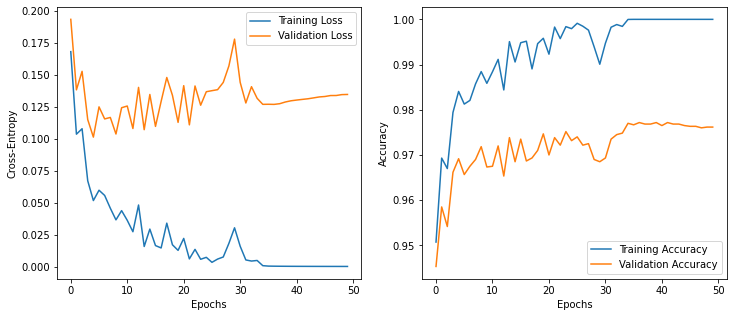

In [13]:
plot_history(history)

## Data Augmentation in PyTorch

The first technique we are going to try out in order to combat overfitting is `data augmentation`.

In [14]:
# function to loop over a list of images and to draw them using matplotlib
def draw_images(images):
    fig = plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        img = img.squeeze()
        plt.imshow(img, cmap="gray")
        plt.axis('off')

Below are the original images that we used in the training below.

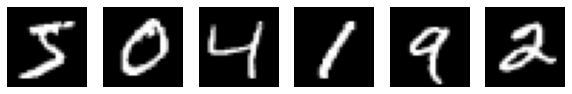

In [15]:
# original images
images = [train_validation_dataset[i][0] for i in range(6)]
draw_images(images)

But Torchvision provides [transforms](https://pytorch.org/vision/stable/transforms.html), specifically designed for data augmentation.

The `RandomRotation` transform below rotates images between -30 and 30 degrees.

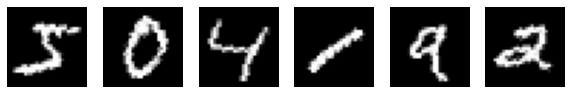

In [16]:
# rotate
transform = T.RandomRotation(degrees=(-30, 30))
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

The `GaussianBlur` blurs the images randomly.

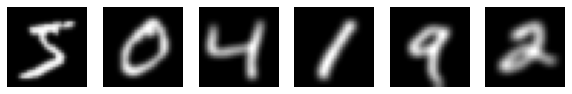

In [17]:
# gaussian blur
transform = T.GaussianBlur(kernel_size=(5,5))
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

And the `RandomHorizontalFlip` flips the images with probablity p horizontally.

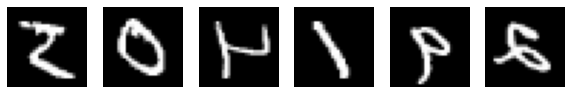

In [18]:
# flip
transform = T.RandomHorizontalFlip(p=1)
transformed_images = [transform(img) for img in images]
draw_images(transformed_images)

There are many more different transforms available, but in this example we will only apply two. Rirst we rotate the `PIL` image between -10 and +10 degres and then we apply a gaussian blur.

In [19]:
transform = T.Compose([
    T.RandomRotation(degrees=(-10, 10)),
    T.GaussianBlur(kernel_size=(5,5)),
    T.ToTensor(),
])

As we have created new transforms, we have to to create a new training dataset and dataloader. The validation dataset is not going to change, because we are interested in the performance of our real dataset.

In [20]:
train_validation_dataset_aug = MNIST(root="../datasets/", train=True, download=True, transform=transform)
train_dataset_aug = Subset(train_validation_dataset_aug, train_idxs)

train_dataloader_aug = DataLoader(dataset=train_dataset_aug, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True,
                              num_workers=4)

Let us initialize training again and see if this is sufficient to combat overfitting:

In [21]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=ALPHA)

In [22]:
history = train(train_dataloader_aug, val_dataloader, model, criterion, optimizer)

Epoch: 1/50 | Train Loss: 0.23017700900896174 | Val Loss: 0.21242613207300504
Epoch: 10/50 | Train Loss: 0.11676552592094648 | Val Loss: 0.11722436376040181
Epoch: 20/50 | Train Loss: 0.08177606587115484 | Val Loss: 0.10033401938900352
Epoch: 30/50 | Train Loss: 0.05657424899516489 | Val Loss: 0.09394760690722614
Epoch: 40/50 | Train Loss: 0.06412839304358231 | Val Loss: 0.09732028384134174
Epoch: 50/50 | Train Loss: 0.06161401156230074 | Val Loss: 0.09745586793295419


The performance measured on the validation dataset follows the one measured on the training dataset closely and there are fewer signs of overfitting. While you will notice when you train this model yourself that the 50 epochs take more time to finish, because the data transformations are applied to each new batch, this is still a powerfull techinque if you face overfitting. 

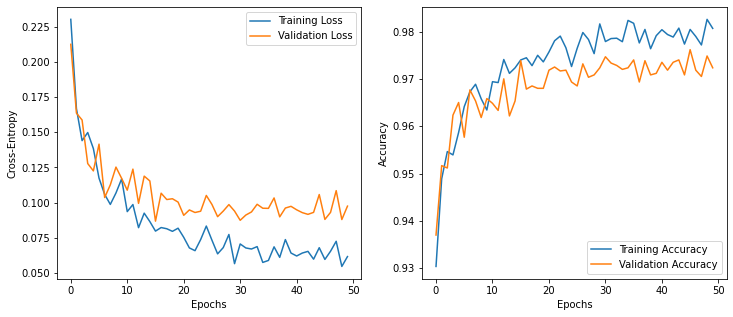

In [23]:
plot_history(history)

## L2 Regularization in PyTorch

It is extremely easy to implement $L_2$ regularization in PyTorch. All you have to do is to initialize the optimizer with a `weight_decay` argument. The higher the number, the larger the impact on the loss function and the simpler the model is going to become.

In [24]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=ALPHA, weight_decay=0.0001)

In [25]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/50 | Train Loss: 0.2692966635477529 | Val Loss: 0.30114026117324827
Epoch: 10/50 | Train Loss: 0.05171263221769732 | Val Loss: 0.12303573771907637
Epoch: 20/50 | Train Loss: 0.048371113236255106 | Val Loss: 0.1487303650023726
Epoch: 30/50 | Train Loss: 0.014429675678123543 | Val Loss: 0.10735447920078878
Epoch: 40/50 | Train Loss: 0.02232380158147161 | Val Loss: 0.1206393248072515
Epoch: 50/50 | Train Loss: 0.008002975791913712 | Val Loss: 0.09944692831300199


In our case this procedure was not as successfull, as data augmentation. Often you will have to try out different techniques and tweak the parameters to see if can get better results.

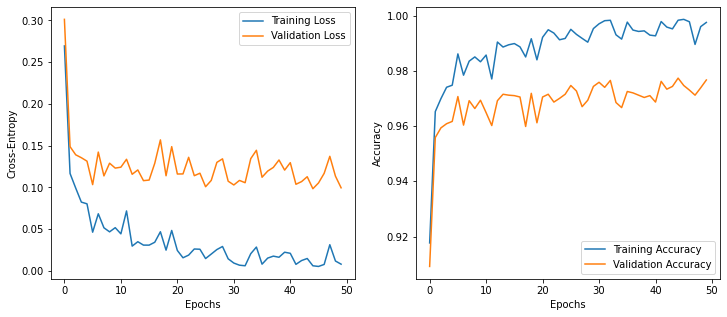

In [26]:
plot_history(history)

## Dropout in PyTorch

Dropout is implemented as a layer in PyTorch. The `nn.Dropout` layer zeroes out the values of the previous layer with probability $p$ and multiplies the remaining nodes with $\dfrac{1}{1-p}$. Pick a place in the model where you would want that to happen and add a `nn.Dropout(p)` layer.

In [27]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(NUM_FEATURES, HIDDEN_SIZE_1),
                nn.Sigmoid(),
                nn.Dropout(p=0.6),
                nn.Linear(HIDDEN_SIZE_1, HIDDEN_SIZE_2),
                nn.Sigmoid(),
                nn.Dropout(p=0.6),
                nn.Linear(HIDDEN_SIZE_2, NUM_LABELS),
            )
    
    def forward(self, features):
        return self.layers(features)

In [28]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=ALPHA)

In [29]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/50 | Train Loss: 0.4554739745546885 | Val Loss: 0.46008577624956765
Epoch: 10/50 | Train Loss: 0.23380841458603854 | Val Loss: 0.257760927627484
Epoch: 20/50 | Train Loss: 0.21072692851020905 | Val Loss: 0.24204068488876024
Epoch: 30/50 | Train Loss: 0.20063898156032134 | Val Loss: 0.2377141117453575
Epoch: 40/50 | Train Loss: 0.18645740339143846 | Val Loss: 0.23551244089007378
Epoch: 50/50 | Train Loss: 0.1665979035071163 | Val Loss: 0.2209140519897143


When we introduce dropout we do not seem to hit the limit in performance even after 50 epochs. This is  common when we introduce dropout techniques. It usually takes a lot longer to gain a decent performance, so you might need to change the architecture of your model and tweak some other paramters. 

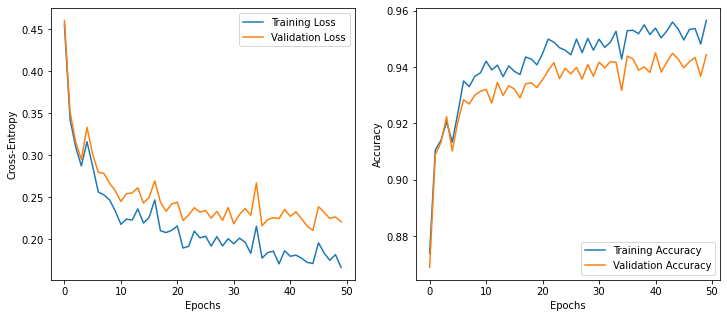

In [30]:
plot_history(history)

In our trials data augmentation seems to be the most powerful technique, even though it is the easiest techinique. 